In [1]:
import tensorflow as tf
import numpy as np
from predictor import Predictor
from models import *
import matplotlib.pyplot as plt
import pandas as pd
import math
from  models import esum2
import random

In [20]:
sample_width = 1
input_width = 64
sections = int(math.log2(input_width))
model =  keras.models.load_model("models/trendencoder")
predictor = Predictor(datafile="datas/EURUSD_H1 copy.csv",model=model,input_width=input_width,label_width=1,sample_width=sample_width,shift=1,train_ratio=0.8,val_ratio=0.1,test_ratio=0.1,batch_size=2**12)


In [21]:
df = pd.read_csv(
    "datas/EURUSD_H1 copy.csv",
    sep="\t",
    nrows=2**16,
    header=0,
    dtype={"open": np.float32,"close": np.float32,"tickvol": np.float32,"vol": np.float32},
    parse_dates=[[0,1]],
    index_col=[0],
    names=["date","time","open","high","low","close","tickvol","vol","spread"])
t_count = 2**8
t_shift = random.randint(0,2**10)
prices = df['open'][-t_count-t_shift:-1-t_shift]

shift = predictor.dataloader.input_width
ds = predictor.dataloader.make_dataset(prices)
for i,l in ds:
    print(i.shape, l.shape)

labels = (l.numpy().flatten()*100000).round(1)
print(i.numpy()[shift+16:].flatten())
print(labels)


(191, 64, 1) (191, 1, 1)
[1.17659 1.17727 1.17596 ... 1.18917 1.18928 1.1885 ]
[  61.  -16.  -37.   16. -132. -115.   17. -131.   12. -189. -116.   68.
  -42.  -85.   95.   -7.  -78.  -10.  -22.   48.  -56.  -26.    7.    5.
  203.  -93.    0.   -9.  190.  -34.  228.   34.  114.  -67.   82.   43.
   -4.   22.    6.   -4.  126.   89. -160.   30.   37.  259. -155. -116.
  -56.  159.   -2.  -58. -170. -123.   72. -177.    6. -151.  -76.  109.
 -150.  -12.  241.  -61.  124.  -13.   87.  171.   32. -137.   91.  156.
  134.  -49.  -90. -101.   11.   -4.  -62.   10.   65.  174.   -5.  132.
   81.   34.  -44.  -62.  -57.   55.   10.   74.  -71.    8.   59.  137.
 -277.   31.   41.  -30.  -95.   19. -105.   25.  239.  -17.   28.  162.
 -299.  -38.   -8.   -8.   28.  125.   61.   -9.   11.   31.    7.  201.
 -584.  -71.  -38.   33.  -63.   79.  -98.  -67.  -23. -373.   25. -110.
   52.  313.   -4.    7.   28.   87. -249.  146.    9.   66.   56.  157.
   -8.  108.  -31.   48.  -24.  126.  169. -1

2/2 [==============================] - 0s 2ms/step


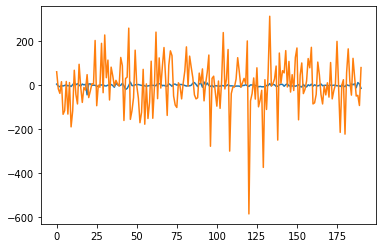

In [23]:
result = predictor.predict(prices)[:-1]
outputs = (result.flatten()*100000).round(1)
t = np.arange(len(result))
plt.plot(t,result*100000)
plt.plot(t,labels)
